<a href="https://colab.research.google.com/github/Qvery-mm/NumericMethods_3/blob/main/6_term_lab04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Вычислительный практикум, 6 семестр
# Задание №4
# Метод сеток для решения уравнения параболического типа
### Ковальчуков Александр
### 321 группа
### Вариант №6

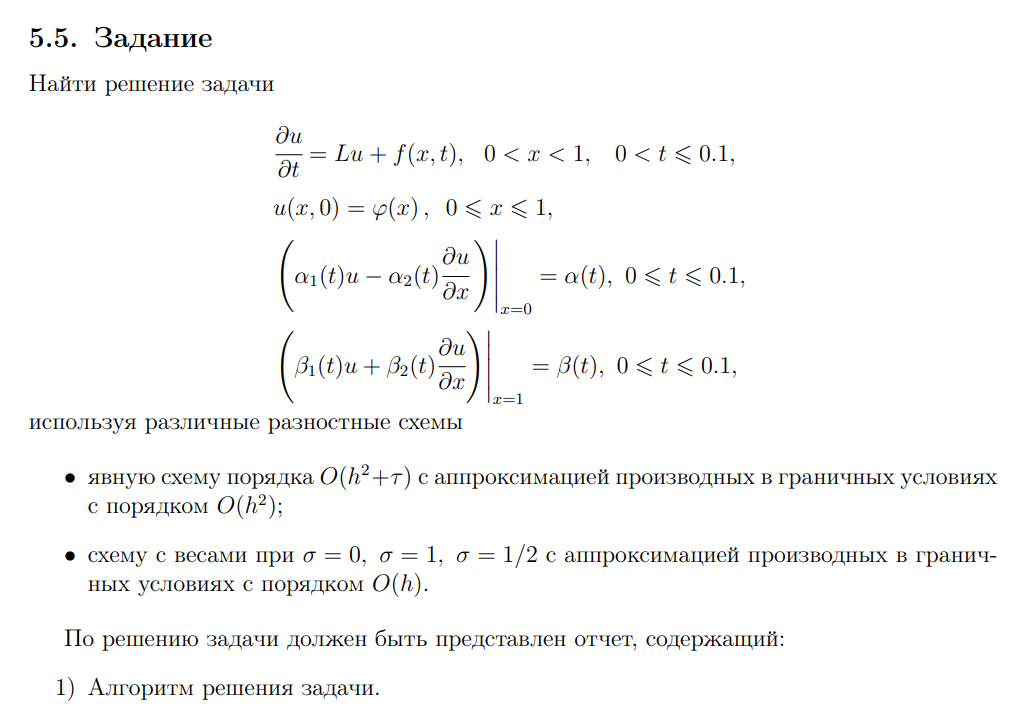

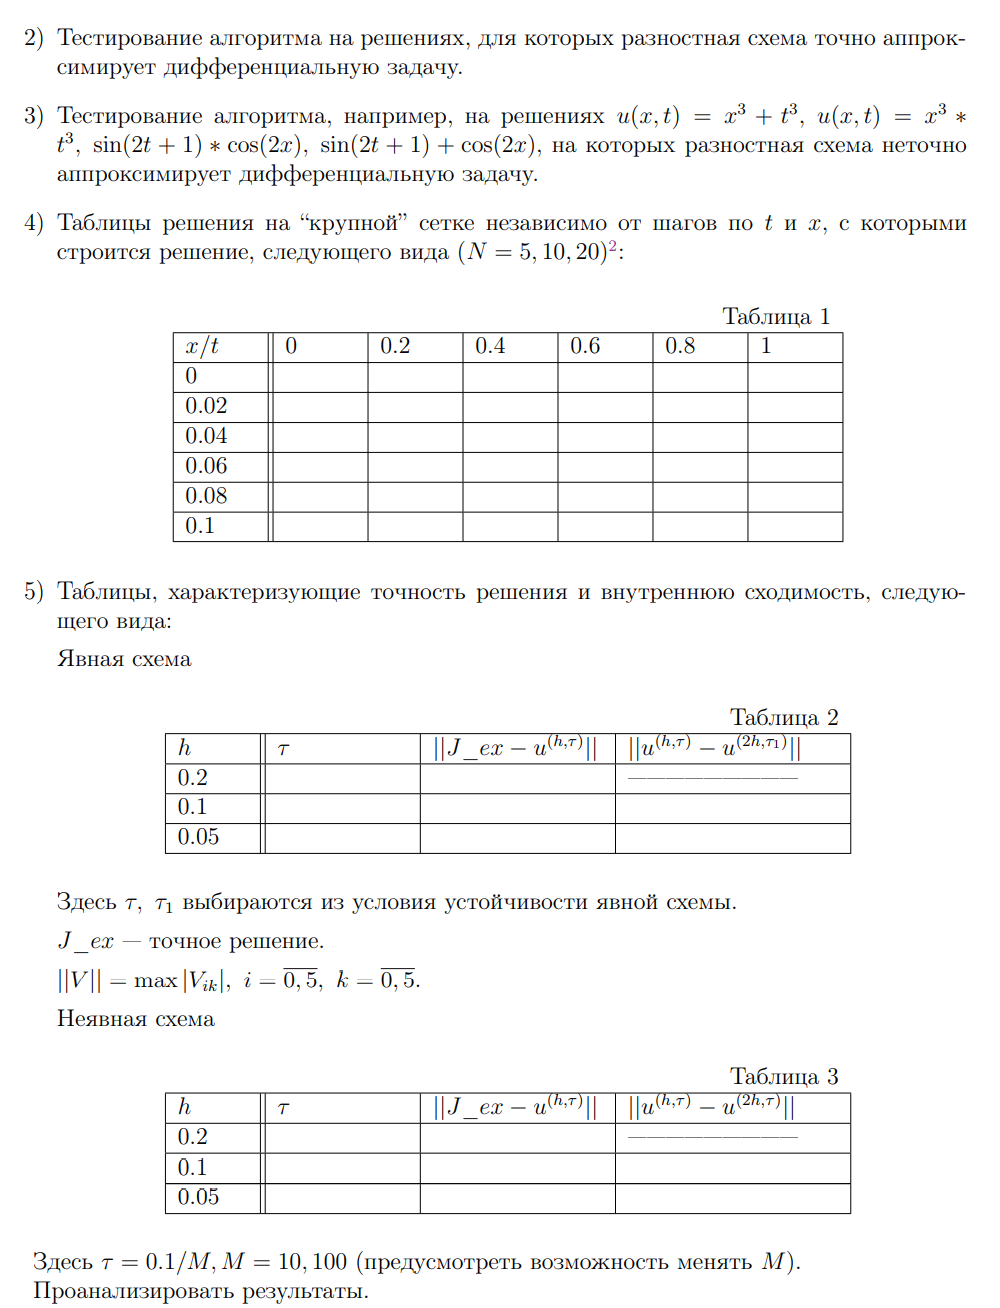

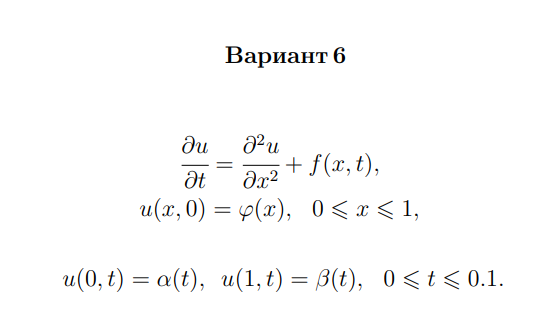

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import *

Алгоритм надо протестировать на различных решениях. Определим их здесь.


In [2]:
tests_u = [lambda x, t: x,
          lambda x, t: t,
          lambda x, t: x + t,
          lambda x, t: x**3 + t**3,
          lambda x, t: x**3 * t**3,
          lambda x, t: sin(2*t + 1) * cos(2*x),
          lambda x, t: sin(2 * t + 1) + cos(2 * x)
          ]

Вспомогательные функции для вычисления $f, \varphi, \alpha, \beta$ тестовых функций.

In [3]:
def d_dt(u):
  eps = 1e-4
  return lambda x, t: (u(x, t + eps) - u(x, t - eps)) / (2 * eps)

def d_dx(u):
  eps = 1e-4
  return lambda x, t: (u(x + eps, t) - u(x - eps, t)) / (2 * eps)

In [4]:
def evaluate_f(u):
  return lambda x, t: d_dt(u)(x, t) - d_dx(d_dx(u))(x, t)

In [5]:
tests_phi = list(map(lambda u: lambda x: u(x, 0), tests_u))
tests_alpha = list(map(lambda u: lambda t: u(0, t), tests_u))
tests_beta = list(map(lambda u: lambda t: u(1, t), tests_u))
tests_f = list(map(lambda u: evaluate_f(u), tests_u))

In [6]:
class Test:
  def __init__(self, data):
    u, f, phi, alpha, beta = data
    self.u = u
    self.f = f
    self.phi = phi
    self.alpha = alpha
    self.beta = beta

tests = list(map(Test, zip(tests_u, tests_f, tests_phi, tests_alpha, tests_beta))) # Итоговый массив тестов
  

# Явная схема порядка $O(h^2 + \tau)$

## Имеются уравнения (5) -- (8), также алгоритм решения.

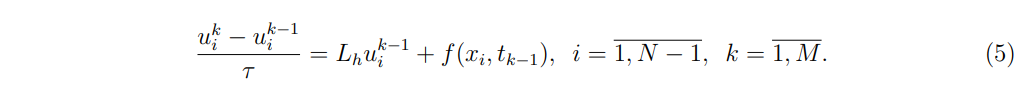

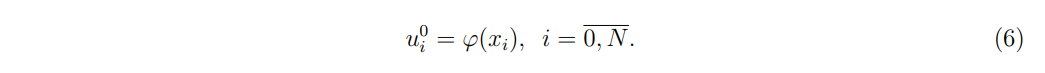

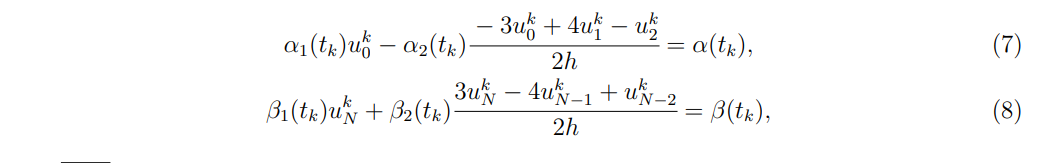

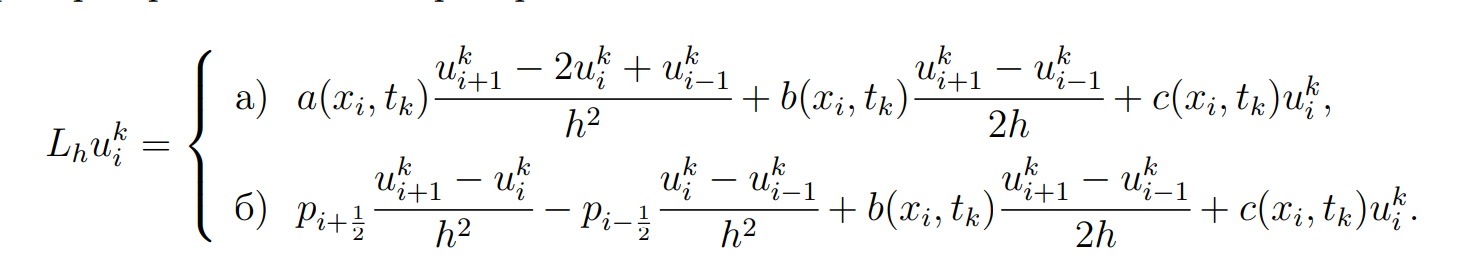

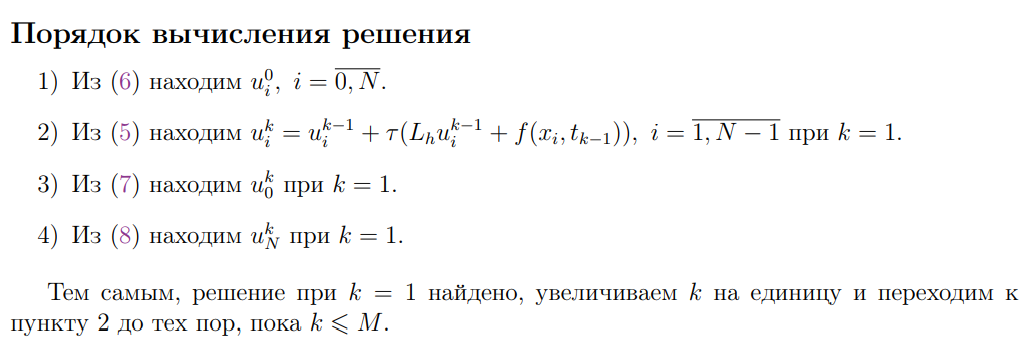

In [7]:
def run_test_exact(n_test, N, M, show_matrix=False):
  T = 0.1
  h = 1.0 / N
  tau = T / M
  test = tests[n_test]
  u = np.zeros((N+1, M+1))
  k = 0
  for i in range(N+1):
    x = i * h
    u[i, k] = test.phi(x)

  while(k < M):
    k += 1
    for i in range(1, N):
      x = i * h
      t = k * tau
      u[i, k] = u[i, k-1] + tau * ((u[i+1, k-1] - 2 * u[i, k-1] + u[i-1, k-1]) / h**2 + test.f(x, tau * (k - 1)))
      u[0, k] = test.alpha(t)
      u[N, k] = test.beta(t)
  

  norm = 0
  for i in range(N+1):
    for j in range(M+1):
      x = i * h
      t = k * tau
      norm = max(norm, abs(u[i, k] - tests[n_test].u(x, t)))
  # print(f'Точность на {n_test} тесте: {norm}')

  if show_matrix:
    print('\nТаблица решения в узлах сетки:\n')
    print( pd.DataFrame(u.T, columns=list(np.linspace(0,1,6)), index=list(np.linspace(0,0.1,6))))

  return norm, u  

## Таблица решения для нулевого теста на крупной сетке.

In [8]:
run_test_exact(0, 5, 5, show_matrix=True)
pass


Таблица решения в узлах сетки:

      0.0  0.2  0.4  0.6  0.8  1.0
0.00  0.0  0.2  0.4  0.6  0.8  1.0
0.02  0.0  0.2  0.4  0.6  0.8  1.0
0.04  0.0  0.2  0.4  0.6  0.8  1.0
0.06  0.0  0.2  0.4  0.6  0.8  1.0
0.08  0.0  0.2  0.4  0.6  0.8  1.0
0.10  0.0  0.2  0.4  0.6  0.8  1.0


In [9]:
for i in range(len(tests)):
  print(f'Точность на {i} тесте: {run_test_exact(i, N=6, M=6)[0]}')
  

Точность на 0 тесте: 0
Точность на 1 тесте: 1.6237011735142914e-15
Точность на 2 тесте: 1.0769163338864018e-14
Точность на 3 тесте: 0.00021547037877681086
Точность на 4 тесте: 5.8671178126951606e-05
Точность на 5 тесте: 0.002930710392911151
Точность на 6 тесте: 0.003928564860850692


# Схема с весами

Для нашей задачи коэффициенты система уранений имеет следующий вид:

$u[i, 0] = \varphi(x_i)$

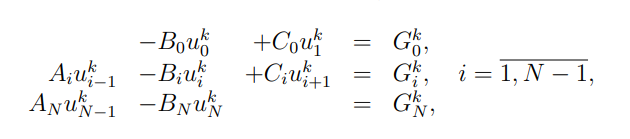

где 

$B_0 = -1, \; C_0 = 0, \; G_0 = \alpha(t_k)$

$A_i = -\dfrac \sigma {h^2}, \; B_i = - \dfrac 1{\tau} + \dfrac{2\sigma}{h^2}, \; C_i = -\dfrac \sigma {h^2}, 
G_i =  \dfrac 1{tau} u_i^{k-1} + \dfrac{1 - \sigma}{h^2} (u_{i+1}^{k-1} - 2 u_i^{k-1} + u_{i-1}^{k-1}) + f(x_i, t_k)
\quad i = 1\dots n-1$

$A_0 = 0, \; B_0 = -1, \; G_0 = \beta(t_k)$

Система решается методом прогонки.

In [10]:
def run_test_weight(n_test, N, M, sigma, show_matrix=False):
    T = 0.1
    h = 1.0 / N
    tau = T / M
    test = tests[n_test]
    u = np.zeros((N+1, M+1))
    k = 0
    for i in range(N+1):
        x = i * h
        u[i, k] = test.phi(x)

    while(k < M):
        k += 1
        t = k * tau
        A, B, C, G, s, t_list = [], [], [], [], [], []

        for i in range(N+1):
            x = i * h
            if i == 0:
              A_i, B_i, C_i, G_i, s_i = 0, -1, 0, test.alpha(t), 0  
              t_i = -G_i / B_i
              
            elif i == N:
              A_i, B_i, C_i, G_i, s_i = 0, -1, 0, test.beta(t), 0    
              t_i = test.beta(t)

            else:
              A_i = -sigma / h**2
              B_i = -(1/tau + 2 * sigma / h**2)
              C_i = -sigma / h**2
              G_i = 1/tau * u[i, k-1] + (1 - sigma) / h**2 * (u[i+1, k-1] - 2 * u[i, k-1] + u[i-1, k-1]) + test.f(x, t)
              s_i = C_i / (B_i - A_i * s[-1])
              t_i = (A_i * t_list[-1] - G_i) / (B_i - A_i * s[-1])

            A.append(A_i)
            B.append(B_i)
            C.append(C_i)
            G.append(G_i)
            s.append(s_i)
            t_list.append(t_i)
        
        row = [t_i]
        for i in range(N):
            j = N - i - 1
            u_j = s[j] * row[-1] + t_list[j]
            row.append(u_j)
        row = row[::-1]
        for i in range(N+1):
            u[i, k] = row[i]

    if show_matrix:
      print(pd.DataFrame(u.T))

    norm = 0
    for i in range(N+1):
        for j in range(M+1):
            x = i * h
            t = k * tau
            norm = max(norm, abs(u[i, k] - tests[n_test].u(x, t)))
    # print(f'Точность на {n_test} тесте: {norm}')

    return norm, u


In [11]:
for i in range(len(tests)):
  print(f'Точность на {i} тесте: {run_test_weight(i, N=6, M=6, sigma=0)[0]}')
  

Точность на 0 тесте: 0
Точность на 1 тесте: 2.067790383364354e-15
Точность на 2 тесте: 1.326716514427062e-14
Точность на 3 тесте: 0.00023700962011563576
Точность на 4 тесте: 1.3530081131811326e-05
Точность на 5 тесте: 0.0028219934160615967
Точность на 6 тесте: 0.0012499014275353382


# Таблицы точности решения явной схемы 

Условие устойчивости явной схемы:
$\dfrac \tau {h^2} \leq \dfrac 1 2$, $\tau \leq \dfrac {h^2} 2$
Для 5 пункта задания нас устроит $\tau = \tau_1 = 0.001$

In [12]:
def rel_norm(A, B):
  norm = 0
  for i in range(A.shape[0]):
    for j in range(A.shape[1]):
      norm = max(norm, abs(A[i, j] - B[2*i, j]))
  return norm


for n_test in range(len(tests)):
  data = pd.DataFrame(columns=['h', 'tau', 'abs norm', 'rel norm'])
  M = 100
  tau = 0.1 / M
  

  for N in [4, 10, 20]:
    h = 1 / N
    abs_norm, u1 = run_test_exact(n_test, int(N/2), M)
    abs_norm, u2 = run_test_exact(n_test, N, M)
    row = {'h': h, 'tau': tau, 'abs norm': abs_norm, 'rel norm': rel_norm(u1, u2)}
    data = data.append(row, ignore_index=True)
  print('\nТест', n_test)
  print(data)



Тест 0
      h    tau  abs norm  rel norm
0  0.25  0.001       0.0       0.0
1  0.10  0.001       0.0       0.0
2  0.05  0.001       0.0       0.0

Тест 1
      h    tau      abs norm      rel norm
0  0.25  0.001  1.387779e-15  8.326673e-17
1  0.10  0.001  1.512679e-15  4.163336e-17
2  0.05  0.001  1.623701e-15  1.110223e-16

Тест 2
      h    tau      abs norm      rel norm
0  0.25  0.001  5.329071e-15  1.776357e-15
1  0.10  0.001  2.071177e-12  3.175848e-12
2  0.05  0.001  2.190970e-12  3.702733e-12

Тест 3
      h    tau  abs norm      rel norm
0  0.25  0.001  0.000013  9.458603e-07
1  0.10  0.001  0.000013  2.049481e-07
2  0.05  0.001  0.000013  5.455435e-08

Тест 4
      h    tau  abs norm      rel norm
0  0.25  0.001  0.000003  5.644755e-07
1  0.10  0.001  0.000004  1.774330e-07
2  0.05  0.001  0.000004  4.712545e-08

Тест 5
      h    tau  abs norm  rel norm
0  0.25  0.001  0.003113  0.007933
1  0.10  0.001  0.000597  0.001534
2  0.05  0.001  0.000211  0.000389

Тест 6
      h 

# Таблицы точности неявной схемы

In [13]:
for sigma in [0, 0.5, 1]:
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('sigma = ', sigma)
  for n_test in range(len(tests)):
    data = pd.DataFrame(columns=['h', 'tau', 'abs norm', 'rel norm'])
    M = 100
    tau = 0.1 / M
    

    for N in [4, 10, 20]:
      h = 1 / N
      abs_norm, u1 = run_test_weight(n_test, int(N/2), M, sigma)
      abs_norm, u2 = run_test_weight(n_test, N, M, sigma)
      row = {'h': h, 'tau': tau, 'abs norm': abs_norm, 'rel norm': rel_norm(u1, u2)}
      data = data.append(row, ignore_index=True)
    print('\nТест', n_test)
    print(data)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sigma =  0

Тест 0
      h    tau      abs norm      rel norm
0  0.25  0.001  0.000000e+00  0.000000e+00
1  0.10  0.001  0.000000e+00  0.000000e+00
2  0.05  0.001  5.551115e-17  2.775558e-17

Тест 1
      h    tau      abs norm      rel norm
0  0.25  0.001  1.429412e-15  1.249001e-16
1  0.10  0.001  1.526557e-15  6.938894e-17
2  0.05  0.001  1.609823e-15  8.326673e-17

Тест 2
      h    tau      abs norm      rel norm
0  0.25  0.001  5.218048e-15  1.776357e-15
1  0.10  0.001  1.962597e-12  3.175737e-12
2  0.05  0.001  2.255224e-12  3.702677e-12

Тест 3
      h    tau  abs norm      rel norm
0  0.25  0.001  0.000013  9.517623e-07
1  0.10  0.001  0.000013  2.060099e-07
2  0.05  0.001  0.000013  5.483103e-08

Тест 4
      h    tau      abs norm      rel norm
0  0.25  0.001  7.520618e-07  3.814981e-07
1  0.10  0.001  7.429000e-07  9.934321e-08
2  0.05  0.001  7.718385e-07  2.758507e-08

Тест 5
      h    tau  abs norm  rel norm
0  0.25  0.001  0.0

# Выводы

Неявная схема даёт существенно большую точность по сравнению с явной. Значения параметра $\sigma$, близкие к 1 также увеличивают точность решения, но текущая вычислительная схема позволяет оценить его влияние очень посредственно, поскольку в описании тестов использован метод численного дифференцирования не очень высокого порядка точности. Кроме того, мы ограничены точностью представления вещественных чисел в памяти компьютера. Однако полученные данные позволяют судить о том, что в первых трёх тестах метод точно аппроксимирует исходное решение.  